<a href="https://colab.research.google.com/github/KorintusDr/Klasifikasi-Buah-dengan-CNN/blob/main/Modell.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Download Depedensi**

In [ ]:
%%capture
!pip install --upgrade tensorflow tensorflowjs kaggle

# **Import Libary**

In [ ]:
import os
import time
import shutil
import sklearn
import numpy as np
import pandas as pd
from PIL import Image
import tensorflow as tf
import tensorflowjs as tfjs
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

import warnings

tf.get_logger().setLevel('ERROR')
warnings.filterwarnings('ignore')

# **Data Collection**

In [ ]:
#from google.colab import files
#files.upload()

In [ ]:
!kaggle datasets download moltean/fruits -p . --unzip

Dataset URL: https://www.kaggle.com/datasets/moltean/fruits
License(s): CC-BY-SA-4.0
100% 961M/964M [00:11<00:00, 113MB/s]
100% 964M/964M [00:11<00:00, 91.6MB/s]


In [ ]:
source_folder = "fruits-360_dataset_original-size/fruits-360-original-size"
destination_folder = "fruits-360-original-size"

if os.path.exists(source_folder):
    shutil.move(source_folder, destination_folder)
    print("Folder berhasil dipindahkan!")
else:
    print("Folder sumber tidak ditemukan.")

Folder berhasil dipindahkan!


In [ ]:
folders_to_delete = ["fruits-360_dataset_100x100", "fruits-360_dataset_original-size"]

for folder in folders_to_delete:
    if os.path.exists(folder):
        shutil.rmtree(folder)
        print(f"Folder {folder} berhasil dihapus.")
    else:
        print(f"Folder {folder} tidak ditemukan.")

Folder fruits-360_dataset_100x100 berhasil dihapus.
Folder fruits-360_dataset_original-size berhasil dihapus.


In [ ]:
original_folder = 'fruits-360-original-size'
new_folder = 'fruits'

if os.path.exists(original_folder):
    os.rename(original_folder, new_folder)
    print(f"Folder '{original_folder}' telah berhasil di-rename menjadi '{new_folder}'.")
else:
    print(f"Folder '{original_folder}' tidak ditemukan.")

Folder 'fruits-360-original-size' telah berhasil di-rename menjadi 'fruits'.


In [ ]:
training_dataset_path = 'fruits/Training'
test_dataset_path = 'fruits/Test'
validation_dataset_path = 'fruits/Validation'
dataset_path = 'fruits/dataset'

def copy_contents(src, dst):
    for item in os.listdir(src):
        s = os.path.join(src, item)
        d = os.path.join(dst, item)
        if os.path.isdir(s):
            if not os.path.exists(d):
                os.makedirs(d)
            copy_contents(s, d)
        else:
            shutil.copy2(s, d)

os.makedirs(dataset_path, exist_ok=True)

copy_contents(training_dataset_path, dataset_path)
copy_contents(validation_dataset_path, dataset_path)
copy_contents(test_dataset_path, dataset_path)

# **Exploratory Data**

Memeriksa distribusi gambar per kela

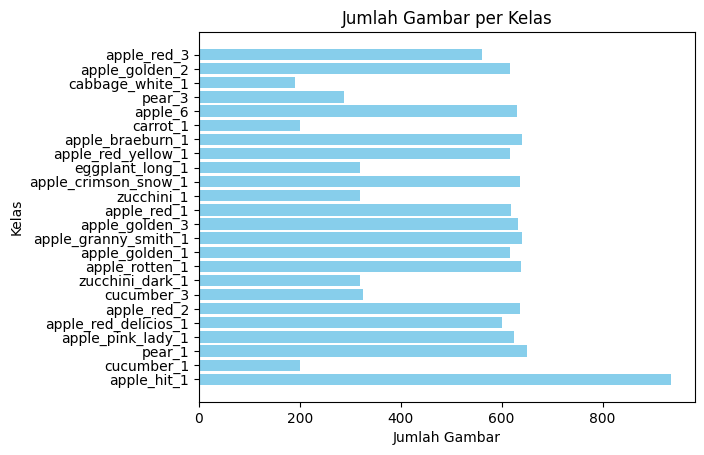

In [ ]:
DIR = 'fruits/dataset'

classes = [i for i in os.listdir(DIR) if os.path.isdir(os.path.join(DIR, i))]
image_counts = [len(os.listdir(os.path.join(DIR, class_name))) for class_name in classes]

plt.barh(classes, image_counts, color='skyblue')
plt.xlabel('Jumlah Gambar')
plt.ylabel('Kelas')
plt.title('Jumlah Gambar per Kelas')
plt.show()

Membuat DataFrame yang berisi path dan label gambar dari dataset

In [ ]:
DIR = 'fruits'

paths = []
labels = []

for root, dirs, files in os.walk(DIR):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg')):
            file_path = os.path.join(root, file)
            paths.append(file_path)

            label = os.path.basename(root)
            labels.append(label)

df = pd.DataFrame({
    'path': paths,
    'label': labels
})
df.head()

,path,label
0,fruits/dataset/apple_hit_1/r0_153.jpg,apple_hit_1
1,fruits/dataset/apple_hit_1/r2_92.jpg,apple_hit_1
2,fruits/dataset/apple_hit_1/r0_225.jpg,apple_hit_1
3,fruits/dataset/apple_hit_1/r2_165.jpg,apple_hit_1
4,fruits/dataset/apple_hit_1/r2_138.jpg,apple_hit_1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24910 entries, 0 to 24909
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   path    24910 non-null  object
 1   label   24910 non-null  object
dtypes: object(2)
memory usage: 389.3+ KB


In [ ]:
df['label'].value_counts()

,count
label,
apple_hit_1,1872
pear_1,1300
apple_granny_smith_1,1280
apple_braeburn_1,1280
apple_rotten_1,1276
apple_red_2,1272
apple_crimson_snow_1,1272
apple_golden_3,1264
apple_6,1260


Melihat jumlah citra dan ukuran resolusi

In [ ]:
def print_images_resolution(directory):
    unique_sizes = set()
    total_images = 0

    for subdir in os.listdir(directory):
        subdir_path = os.path.join(directory, subdir)

        if os.path.isdir(subdir_path):
            image_files = os.listdir(subdir_path)
            num_images = len(image_files)
            print(f"{subdir}: {num_images} gambar")
            total_images += num_images

            for img_file in image_files:
                if len(unique_sizes) >= 5:
                    break
                img_path = os.path.join(subdir_path, img_file)
                with Image.open(img_path) as img:
                    unique_sizes.add(img.size)

            for size in list(unique_sizes)[:5]:
                print(f"- {size}")
            print("---------------")

    print(f"\nTotal gambar: {total_images}")

directory = 'fruits/dataset'
print_images_resolution(directory)

apple_hit_1: 936 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
cucumber_1: 200 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
pear_1: 650 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
apple_pink_lady_1: 625 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
apple_red_delicios_1: 600 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
apple_red_2: 636 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
cucumber_3: 325 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
zucchini_dark_1: 320 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
apple_rotten_1: 638 gambar
- (839, 830)
- (869, 903)
- (908, 853)
- (884, 902)
- (900, 863)
---------------
apple_golden_1: 616 gambar
- (839, 830)


Menampilkan Beberapa Gambar Secara Acak

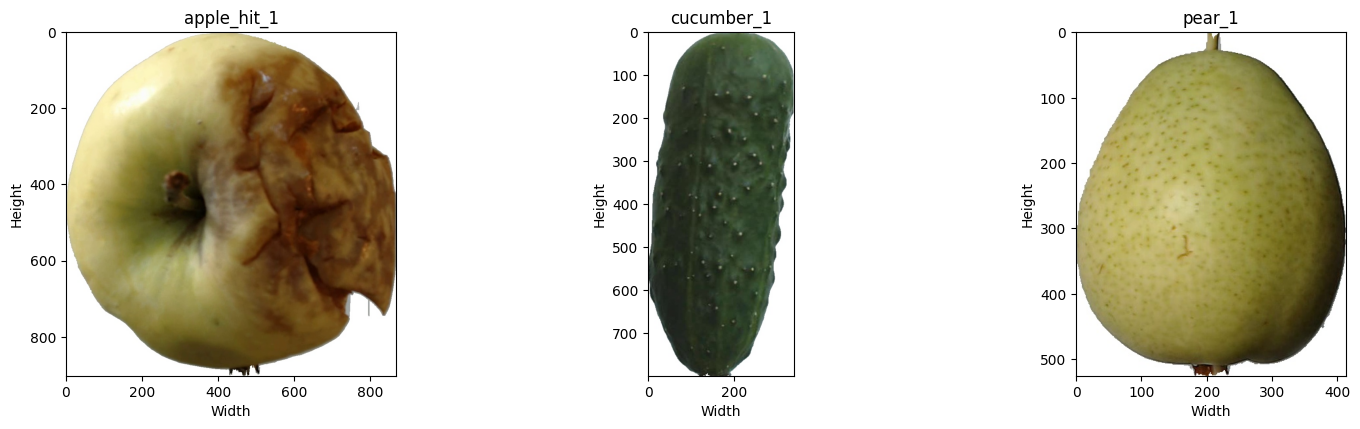

In [ ]:
unique_labels = df['label'].unique()[:3]
plt.figure(figsize=(15, 12))

for idx, label in enumerate(unique_labels):
    plt.subplot(3, 3, idx+1)
    img_path = df[df['label'] == label].iloc[0, 0]
    img = plt.imread(img_path)

    plt.imshow(img)
    plt.title(label)
    plt.xlabel('Width')
    plt.ylabel('Height')

plt.tight_layout()
plt.show()

# **Data Splitting**

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, shuffle=True, random_state=42)

# **Data Preprocessing**

In [ ]:
train_generator = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_generator = ImageDataGenerator(rescale=1./255)

train_images = train_generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    seed=42
)

test_images = test_generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='path',
    y_col='label',
    target_size=(128, 128),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=False
)

Found 19928 validated image filenames belonging to 24 classes.
Found 4982 validated image filenames belonging to 24 classes.


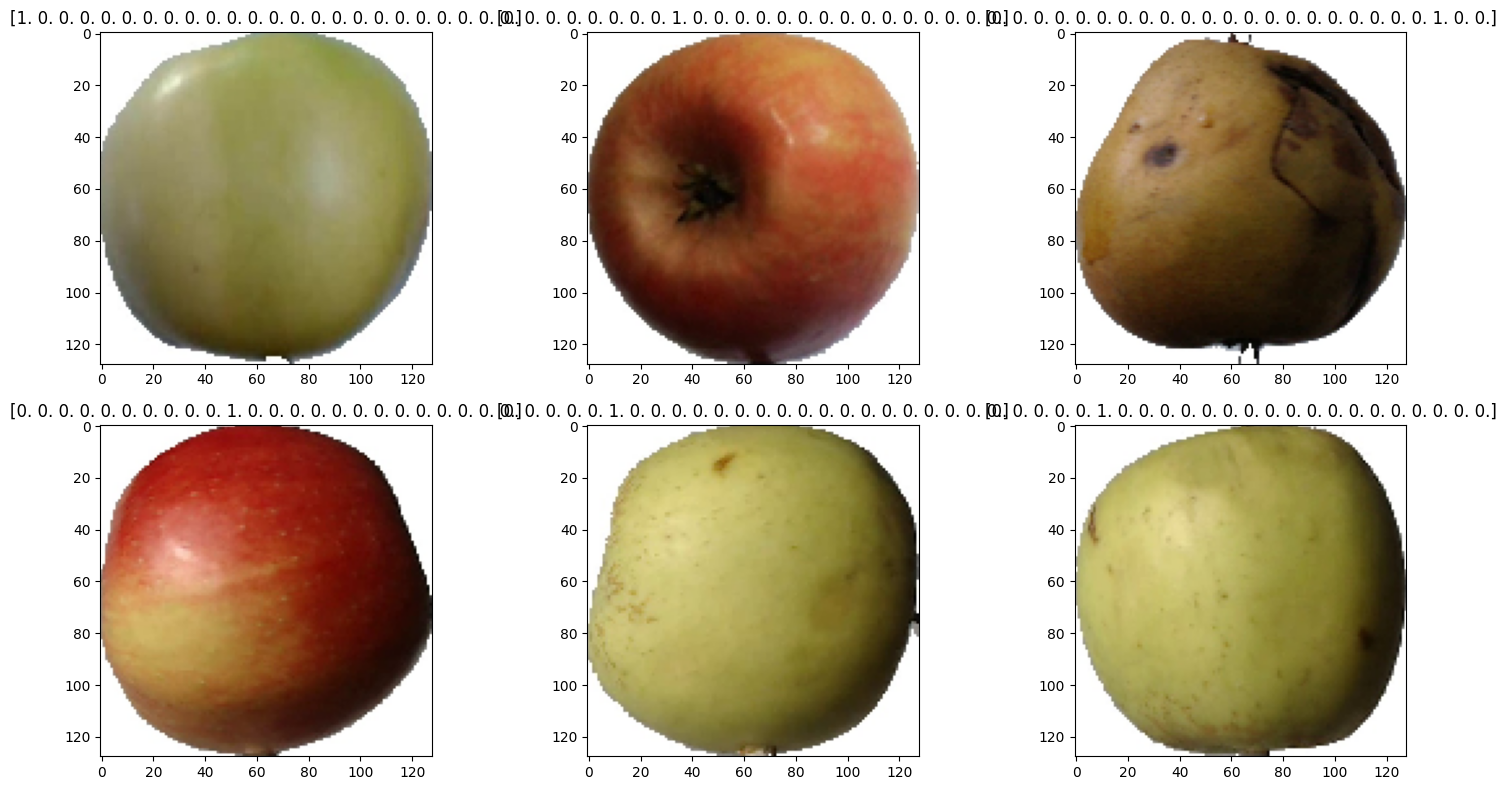

In [ ]:
fig, axes = plt.subplots(2, 3, figsize=(15, 8))

for ax in axes.flat:
    img, label = next(test_images)
    ax.imshow(img[0])
    ax.set_title(str(label[0]))

plt.tight_layout()
plt.show()

# **Modelling**

In [ ]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), input_shape=(128, 128, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(64, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Conv2D(128, (3, 3)),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.MaxPooling2D((2, 2)),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.LeakyReLU(),
    tf.keras.layers.Dropout(0.5),

    tf.keras.layers.Dense(24, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 126, 126, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 126, 126, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 126, 126, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 63, 63, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 61, 61, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 61, 61, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 61, 61, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 30, 30, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 28, 28, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 28, 28, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 14, 14, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 128)                 │       3,211,392 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 24)                  │           3,096 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,309,144 (12.62 MB)

 Trainable params: 3,308,440 (12.62 MB)

 Non-trainable params: 704 (2.75 KB)

In [ ]:
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, min_lr=0.001)

start_time = time.time()

history = model.fit(train_images,
                    validation_data=test_images,
                    epochs=10,
                    steps_per_epoch=100,
                    validation_steps=25,
                    callbacks=[early_stopping, reduce_lr])

end_time = time.time()
training_time = end_time - start_time
print(f"\nWaktu pelatihan: {training_time:.2f} detik ({training_time/60:.2f} menit)")

Epoch 1/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 187s 2s/step - accuracy: 0.3509 - loss: 2.2051 - val_accuracy: 0.0375 - val_loss: 5.5026 - learning_rate: 0.0010
Epoch 2/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 186s 2s/step - accuracy: 0.6703 - loss: 0.9722 - val_accuracy: 0.0375 - val_loss: 7.1529 - learning_rate: 0.0010
Epoch 3/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 201s 2s/step - accuracy: 0.7885 - loss: 0.6825 - val_accuracy: 0.2025 - val_loss: 4.5791 - learning_rate: 0.0010
Epoch 4/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 203s 2s/step - accuracy: 0.8382 - loss: 0.5216 - val_accuracy: 0.5500 - val_loss: 1.5240 - learning_rate: 0.0010
Epoch 5/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8749 - loss: 0.4062 - val_accuracy: 0.7050 - val_loss: 1.0224 - learning_rate: 0.0010
Epoch 6/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 202s 2s/step - accuracy: 0.8840 - loss: 0.3765 - val_accuracy: 0.8238 - val_loss: 0.5357 - learning_rate: 0.0010
Epoch 7/10
100/100 ━━━━━━━━━━━━━━━━━━━━ 81s 804ms/step - accuracy: 0.8794 - loss: 

In [ ]:
train_results = model.evaluate(train_images, verbose=0)
print("Training Loss: {:.5f}".format(train_results[0]))
print("Training Accuracy: {:.2f}%".format(train_results[1] * 100))

test_results = model.evaluate(test_images, verbose=0)
print("Test Loss: {:.5f}".format(test_results[0]))
print("Test Accuracy: {:.2f}%".format(test_results[1] * 100))

Training Loss: 0.19435
Training Accuracy: 94.42%
Test Loss: 0.09194
Test Accuracy: 96.65%


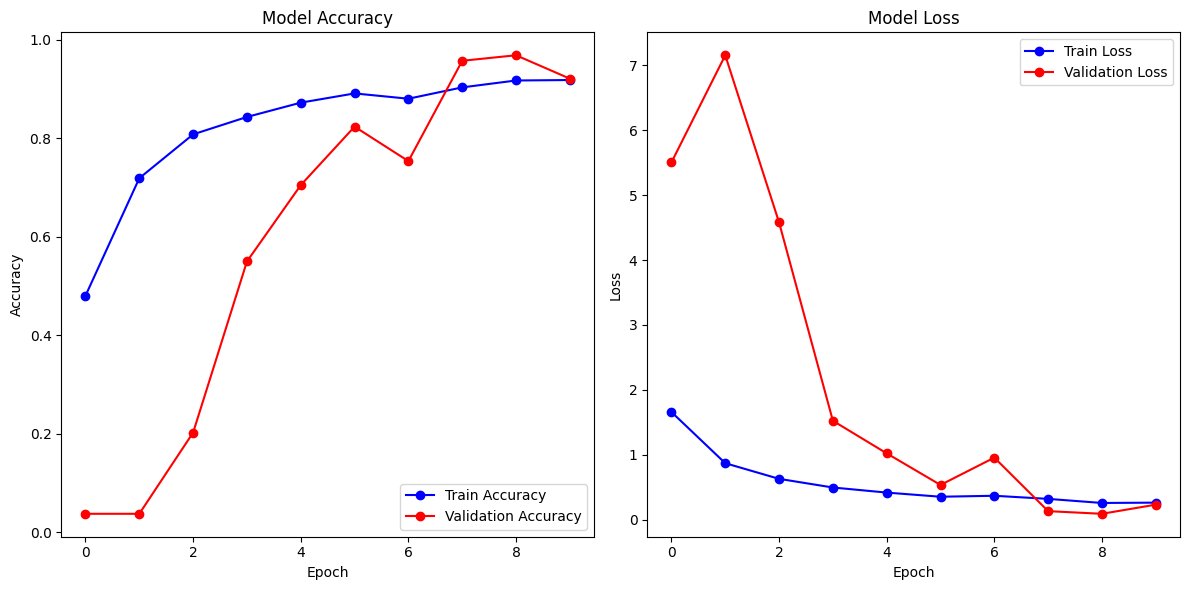

In [ ]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], 'bo-', label='Train Accuracy')
plt.plot(history.history['val_accuracy'], 'ro-', label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')
plt.legend(loc='lower right')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], 'bo-', label='Train Loss')
plt.plot(history.history['val_loss'], 'ro-', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

# **Simpan Mode**

In [ ]:
saved_model_dir = "saved_model"

if not os.path.exists(saved_model_dir):
    os.makedirs(saved_model_dir)

model.export(saved_model_dir)

Saved artifact at 'saved_model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  133521361876560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361875984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361876752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361877328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269392: T

In [ ]:
tfjs_model_dir = "tfjs_model"

if not os.path.exists(tfjs_model_dir):
    os.makedirs(tfjs_model_dir)

tfjs.converters.save_keras_model(model, tfjs_model_dir)

failed to lookup keras version from the file,
    this is likely a weight only file


In [ ]:
tflite_model_dir = "tflite"

if not os.path.exists(tflite_model_dir):
    os.makedirs(tflite_model_dir)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

with open(os.path.join(tflite_model_dir, "model.tflite"), "wb") as f:
    f.write(tflite_model)

with open(os.path.join(tflite_model_dir, "label.txt"), "w") as f:
    f.write("label")

Saved artifact at '/tmp/tmpz4fjm3k0'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 128, 128, 3), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 24), dtype=tf.float32, name=None)
Captures:
  133521361876560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361875984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268816: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268624: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361876752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521361877328: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362268432: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269968: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269584: TensorSpec(shape=(), dtype=tf.resource, name=None)
  133521362269776: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1335213622693

In [ ]:
!pip freeze > requirements.txt
!cat requirements.txt

absl-py==1.4.0
accelerate==1.3.0
aiohappyeyeballs==2.4.4
aiohttp==3.11.11
aiosignal==1.3.2
alabaster==1.0.0
albucore==0.0.23
albumentations==2.0.3
ale-py==0.10.1
altair==5.5.0
annotated-types==0.7.0
anyio==3.7.1
argon2-cffi==23.1.0
argon2-cffi-bindings==21.2.0
array_record==0.6.0
arviz==0.20.0
astropy==7.0.0
astropy-iers-data==0.2025.2.3.0.32.42
astunparse==1.6.3
atpublic==4.1.0
attrs==25.1.0
audioread==3.0.1
autograd==1.7.0
babel==2.17.0
backcall==0.2.0
beautifulsoup4==4.13.1
bigframes==1.34.0
bigquery-magics==0.5.0
bleach==6.2.0
blinker==1.9.0
blis==0.7.11
blosc2==3.0.0
bokeh==3.6.2
Bottleneck==1.4.2
bqplot==0.12.44
branca==0.8.1
CacheControl==0.14.2
cachetools==5.5.1
catalogue==2.0.10
certifi==2025.1.31
cffi==1.17.1
chardet==5.2.0
charset-normalizer==3.4.1
chex==0.1.88
clarabel==0.10.0
click==8.1.8
cloudpathlib==0.20.0
cloudpickle==3.1.1
cmake==3.31.4
cmdstanpy==1.2.5
colorcet==3.1.0
colorlover==0.3.0
colour==0.1.5
community==1.0.0b1
confection==0.1.5
cons==0.4.6
contourpy==1.3.1
cr